In [1]:
import psycopg2
import pandas as pd

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="google_play_reviews",
    user="postgres",
    password="password"
)

# Define a function to fetch reviews for a specified application
def get_reviews_for_app(app_name):
    query = """
    SELECT *
    FROM app_reviews 
    WHERE app_name ILIKE %s
    ORDER BY at DESC;
    """
    reviews_df = pd.read_sql_query(query, conn, params=(f"%{app_name}%",))
    reviews_df = reviews_df.drop(columns=['reply_content', 'replied_at','user_image', 'user_name', 'thumbs_up_count'])
    return reviews_df


In [2]:
# Example usage
app_name = "Strava"
reviews = get_reviews_for_app(app_name)
reviews

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_36584/3615875943.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reviews_df = pd.read_sql_query(query, conn, params=(f"%{app_name}%",))


,review_id,content,score,review_created_version,at,app_version,app_name,country,language
0,9ecbbb9e-6c1b-42df-a478-a52a3459c6c1,The smartwatch app sometimes takes several min...,2,333.10,2024-11-09 16:27:26,333.10,"Strava: Run, Bike, Hike",us,en
1,8ddc73b1-7677-4740-86bd-82c905588cd6,The app does a good job at tracking workouts w...,3,333.10,2024-11-09 16:26:34,333.10,"Strava: Run, Bike, Hike",us,en
2,70895d68-ad95-499f-a993-3aee3680114f,"If it's not on strava, it did not happen.",5,384.11,2024-11-09 11:49:38,384.11,"Strava: Run, Bike, Hike",us,en
3,b4523627-8afb-4076-a722-96f038877582,New version keep going better,5,375.10,2024-11-09 11:06:23,375.10,"Strava: Run, Bike, Hike",us,en
4,89af640b-3654-4976-8180-7a1ae4eacfda,Bug since October 2024: cannot record activity...,1,384.11,2024-11-09 11:04:10,384.11,"Strava: Run, Bike, Hike",us,en
...,...,...,...,...,...,...,...,...,...
8596,ab45f042-51f7-410f-80c4-456b3f11caec,So much fun to follow others and encouragement...,5,325.8,2023-09-26 02:20:13,325.8,"Strava: Run, Bike, Hike",us,en
8597,b2bfcf04-3be0-400a-affc-01928b0a495c,Brilant for all sports simple and loads of info,5,325.8,2023-09-26 02:12:24,325.8,"Strava: Run, Bike, Hike",us,en
8598,26459de1-e5ee-4270-95e7-a90354a56779,Battery drainer,1,325.8,2023-09-25 23:02:47,325.8,"Strava: Run, Bike, Hike",us,en
8599,d8a5867c-6f6e-40f2-b040-efe1e05606ae,For the last 2 week the app come up really slo...,2,325.8,2023-09-25 20:31:31,325.8,"Strava: Run, Bike, Hike",us,en


## blob, nltk, transformers

In [9]:
from transformers import pipeline
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych (przykład: załóżmy, że `reviews` to Twoja ramka danych)
df = reviews

# Sprawdzenie, czy GPU jest dostępne
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Inicjalizacja modelu Transformers z nowym modelem i obsługą GPU
transformer_pipeline = pipeline(
    'sentiment-analysis',
    model='cardiffnlp/twitter-roberta-base-sentiment-latest',
    device=0 if device == "cuda" else -1  # Użycie GPU jeśli dostępne
)

# Funkcja do obliczania sentymentu z wykorzystaniem Transformers
def transformers_sentiment(text):
    if isinstance(text, str) and len(text) > 0:
        result = transformer_pipeline(text[:512])  # Transformers obsługują do 512 znaków na wejściu
        label = result[0]['label']
        # Mapowanie etykiet na numeryczne wyniki
        score_map = {
            'Negative': -1,
            'Neutral': 0,
            'Positive': 1
        }
        return score_map.get(label, 0)  # Domyślnie 0 dla nieznanych etykiet
    else:
        return 0  # Domyślna wartość dla pustego tekstu

# Stosowanie funkcji do kolumny 'content' w DataFrame
df['transformers_sentiment'] = df['content'].apply(transformers_sentiment)

# Konwersja kolumny 'transformers_sentiment' na wartości numeryczne
df['transformers_sentiment'] = pd.to_numeric(df['transformers_sentiment'], errors='coerce')

# Konwersja kolumny 'at' na datetime i ustawienie jako indeks
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df = df.dropna(subset=['at'])  # Usuń wiersze bez daty
df.set_index('at', inplace=True)

# Usunięcie wierszy z brakującymi wartościami sentymentu
df = df.dropna(subset=['transformers_sentiment'])

# Grupowanie sentymentu tygodniowo
sentiment_over_time = df.resample('W').mean()

# Wizualizacja wyników
plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time.index, sentiment_over_time['transformers_sentiment'], label='Transformers (cardiffnlp/twitter-roberta-base)', linestyle='-', marker='o')
plt.title("Sentyment w czasie (Transformers)")
plt.xlabel("Czas")
plt.ylabel("Średni sentyment")
plt.legend()
plt.grid()
plt.show()

Using device: cpu


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [ ]:
import torch
from transformers import pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

df = reviews

# Sprawdzenie dostępności MPS lub CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Inicjalizacja modelu Transformers z obsługą MPS
transformer_pipeline = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    device=0 if device == "cuda" else -1  # Użycie -1 dla CPU/MPS, ponieważ pipeline nie obsługuje bezpośrednio "mps"
)

# Funkcja do przewidywania wyników sentymentu
def predict_transformer_score(text):
    if isinstance(text, str) and len(text) > 0:
        result = transformer_pipeline(text[:512])  # Truncate to 512 characters
        label = result[0]['label']
        # Mapowanie etykiet na numeryczne wyniki
        score_map = {
            '1 star': 1,
            '2 stars': 2,
            '3 stars': 3,
            '4 stars': 4,
            '5 stars': 5
        }
        return score_map.get(label, None)
    return None


# Przewidywanie wyników dla danych
df['predicted_score'] = df['content'].apply(predict_transformer_score)

# Usuwanie wierszy z brakującymi ocenami
evaluation_df = df.dropna(subset=['score', 'predicted_score'])

# Ekstrakcja rzeczywistych i przewidywanych ocen
actual_scores = evaluation_df['score']
predicted_scores = evaluation_df['predicted_score']

# Obliczanie metryk ewaluacyjnych
mse = mean_squared_error(actual_scores, predicted_scores)
mae = mean_absolute_error(actual_scores, predicted_scores)
r2 = r2_score(actual_scores, predicted_scores)

# Wyświetlanie wyników
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Opcjonalne: Wyświetlenie próby wyników
print(evaluation_df[['content', 'score', 'predicted_score']].head())

Using device: mps
Mean Squared Error (MSE): 1.029531449831415
Mean Absolute Error (MAE): 0.528194396000465
R-squared (R2): 0.5939541295778531
                                                               content  score  \
at                                                                              
2024-11-09 16:27:26  The smartwatch app sometimes takes several min...      2   
2024-11-09 16:26:34  The app does a good job at tracking workouts w...      3   
2024-11-09 11:49:38          If it's not on strava, it did not happen.      5   
2024-11-09 11:06:23                      New version keep going better      5   
2024-11-09 11:04:10  Bug since October 2024: cannot record activity...      1   

                     predicted_score  
at                                    
2024-11-09 16:27:26                2  
2024-11-09 16:26:34                4  
2024-11-09 11:49:38                2  
2024-11-09 11:06:23                5  
2024-11-09 11:04:10                1  


## blob, nltk

                              review_id  \
0  a26cd7bf-843a-4f95-b5da-af095a5981da   
1  4f9945dd-e83c-4b64-9a55-5289b6589b86   
2  211f6167-e987-4a5e-a57f-814f985a1c82   
3  5355151c-7b86-468e-bb97-ab4aa94b3324   
4  cde023d8-dfa5-4a96-88d4-c27907674479   

                                             content  score  \
0  Downloading this new version sadly I lost the ...      1   
1  Very good tracking app. Only gripe is this AI ...      5   
2  I have a refund request until now there not gi...      1   
3  Strava is good. But Strava stopped showing mon...      4   
4  Love this app to track your fitness level in r...      5   

  review_created_version                  at app_version  \
0                 384.11 2024-11-07 11:53:27      384.11   
1                 383.11 2024-11-07 09:16:11      383.11   
2                 383.11 2024-11-07 04:45:47      383.11   
3                 383.11 2024-11-07 03:36:08      383.11   
4                 383.11 2024-11-07 02:18:37      383.11   

 

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_20724/507857052.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time = df.groupby(pd.Grouper(key='at', freq='M')).mean(numeric_only=True)


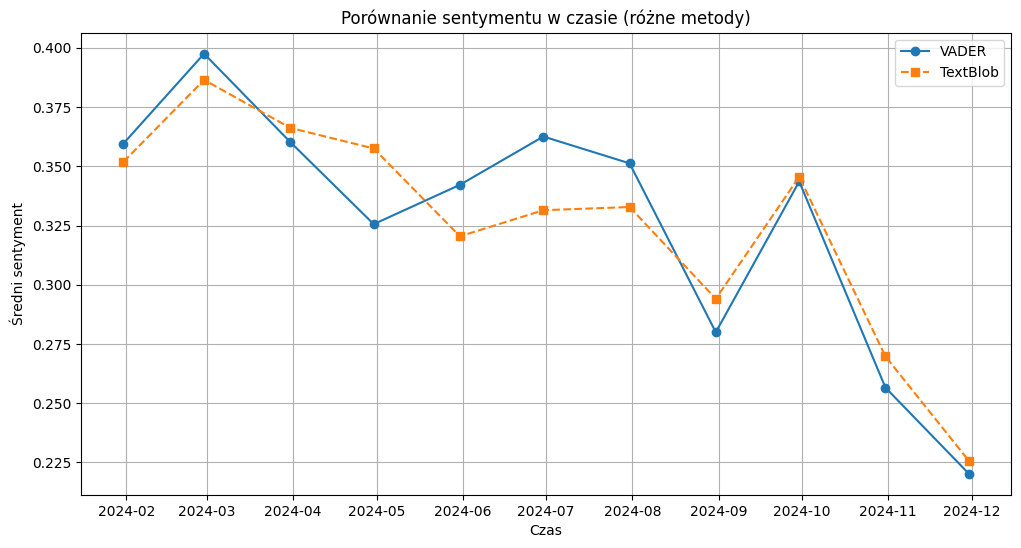

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Wczytanie danych
df = reviews.copy()  # Upewnij się, że reviews to ramka danych
print(df.head())

# Upewnienie się, że kolumna 'at' (data) jest w formacie datetime
df['at'] = pd.to_datetime(df['at'], errors='coerce')

# Inicjalizacja narzędzi do analizy sentymentu
sia = SentimentIntensityAnalyzer()  # VADER

# Obliczanie sentymentu za pomocą VADER
df['vader_sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else None)

# Obliczanie sentymentu za pomocą TextBlob
df['textblob_sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)

# Upewnienie się, że kolumny sentymentu są liczbami
df['vader_sentiment'] = pd.to_numeric(df['vader_sentiment'], errors='coerce')
df['textblob_sentiment'] = pd.to_numeric(df['textblob_sentiment'], errors='coerce')

# Usunięcie błędnych wartości
df = df.dropna(subset=['vader_sentiment', 'textblob_sentiment'])

# Grupowanie danych według miesięcy na podstawie kolumny 'at'
sentiment_over_time = df.groupby(pd.Grouper(key='at', freq='M')).mean(numeric_only=True)

# Wizualizacja wyników
plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time.index, sentiment_over_time['vader_sentiment'], label='VADER', linestyle='-', marker='o')
plt.plot(sentiment_over_time.index, sentiment_over_time['textblob_sentiment'], label='TextBlob', linestyle='--', marker='s')
plt.title("Porównanie sentymentu w czasie (różne metody)")
plt.xlabel("Czas")
plt.ylabel("Średni sentyment")
plt.legend()
plt.grid()
plt.show()

In [4]:
df

,review_id,content,score,review_created_version,at,app_version,app_name,country,language,vader_sentiment,textblob_sentiment
0,a26cd7bf-843a-4f95-b5da-af095a5981da,Downloading this new version sadly I lost the ...,1,384.11,2024-11-07 11:53:27,384.11,"Strava: Run, Bike, Hike",us,en,-0.6031,0.050758
1,4f9945dd-e83c-4b64-9a55-5289b6589b86,Very good tracking app. Only gripe is this AI ...,5,383.11,2024-11-07 09:16:11,383.11,"Strava: Run, Bike, Hike",us,en,0.7913,0.242000
2,211f6167-e987-4a5e-a57f-814f985a1c82,I have a refund request until now there not gi...,1,383.11,2024-11-07 04:45:47,383.11,"Strava: Run, Bike, Hike",us,en,-0.2584,0.000000
3,5355151c-7b86-468e-bb97-ab4aa94b3324,Strava is good. But Strava stopped showing mon...,4,383.11,2024-11-07 03:36:08,383.11,"Strava: Run, Bike, Hike",us,en,-0.1027,0.700000
4,cde023d8-dfa5-4a96-88d4-c27907674479,Love this app to track your fitness level in r...,5,383.11,2024-11-07 02:18:37,383.11,"Strava: Run, Bike, Hike",us,en,0.7430,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
6285,8ca0c317-20ad-4764-b8ae-d51053152a6d,"Great community for athletes, yes that's what ...",5,None,2024-01-01 01:19:52,None,"Strava: Run, Bike, Hike",us,en,0.7783,0.233333
6286,28ffa17c-2328-4df8-afc2-d6d646e130bd,Epic,5,337.13,2024-01-01 01:17:42,337.13,"Strava: Run, Bike, Hike",us,en,0.0000,0.100000
6287,82829ed2-d347-4899-a9e4-93e7713c8609,Records all my details & how well I'm performi...,5,337.13,2024-01-01 01:14:05,337.13,"Strava: Run, Bike, Hike",us,en,-0.0026,0.000000
6288,a4b5307f-ffb0-4b67-af94-d22d4f2e7d9f,For the second year running i tried to sign up...,2,337.13,2024-01-01 01:12:39,337.13,"Strava: Run, Bike, Hike",us,en,-0.3384,-0.133333


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikolajmroz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikolajmroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Największe spadki sentymentu:
           at     score  vader_sentiment  textblob_sentiment  sentiment_change
38 2024-09-29  3.660870         0.289812            0.337130         -0.131983
14 2024-04-14  3.503401         0.239354            0.299511         -0.128973
32 2024-08-18  3.363636         0.197489            0.198797         -0.128236
8  2024-03-03  3.980263         0.344264            0.349738         -0.113124
25 2024-06-30  3.920245         0.269532            0.260054         -0.089308

Najczęściej występujące frazy (problemy) w negatywnych komentarzach w tygodniu 2024-09-29:
- new quick edit: 2 razy
- soon updated almost: 1 razy
- updated almost completely: 1 razy
- almost completely failed: 1 razy
- soon updated almost completely: 1 razy
- updated almost completely failed: 1 razy
- soon updated almost completely failed: 1 razy
- save cycling miles: 1 razy
- many years still: 1 razy
- years still customisation: 1 razy

Najczęściej występujące frazy (problemy) w negatywnyc

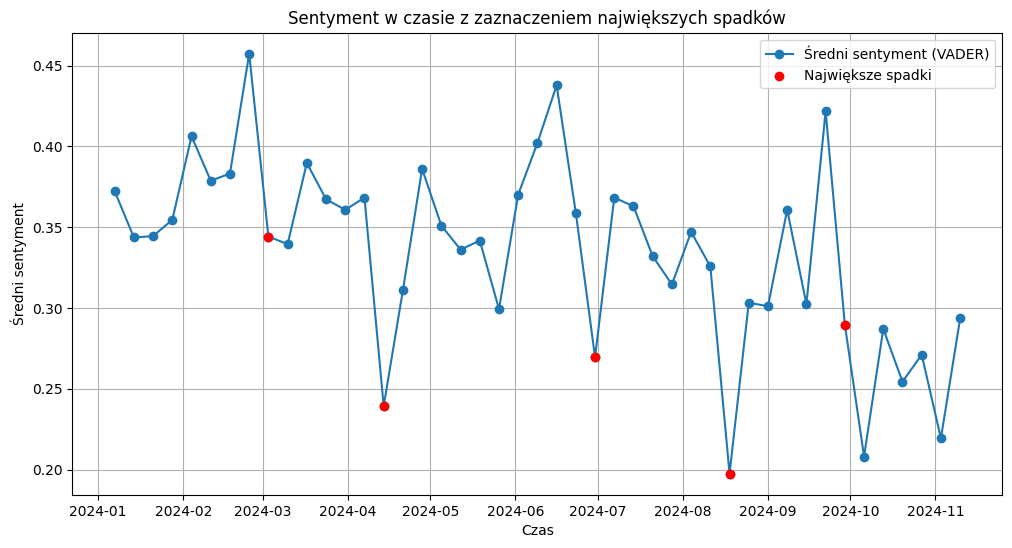

In [14]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import nltk

# Pobranie zasobów NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Upewnij się, że dane w kolumnie 'at' są w formacie datetime
df['at'] = pd.to_datetime(df['at'], errors='coerce')

# Inicjalizacja narzędzia do analizy sentymentu
sia = SentimentIntensityAnalyzer()

# Obliczanie sentymentu za pomocą VADER (jeśli jeszcze nie zostało wykonane)
df['vader_sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else None)

# Usuwanie braków danych
df = df.dropna(subset=['at', 'vader_sentiment'])

# Grupowanie danych tygodniowo dla obliczania średniego sentymentu
weekly_sentiment = df.groupby(pd.Grouper(key='at', freq='W')).mean(numeric_only=True).reset_index()

# Obliczenie różnic w sentymencie (spadki/wzrosty)
weekly_sentiment['sentiment_change'] = weekly_sentiment['vader_sentiment'].diff()

# Znalezienie największych spadków sentymentu
biggest_drops = weekly_sentiment.nsmallest(5, 'sentiment_change')

# Sprawdzenie danych
print("Największe spadki sentymentu:")
print(biggest_drops)

# Funkcja do ekstrakcji najczęstszych dłuższych fraz (n-gramów)
def extract_long_phrases(text_series, min_length=3, max_length=5):
    """Funkcja do ekstrakcji najczęstszych dłuższych fraz z tekstów."""
    stop_words = set(nltk.corpus.stopwords.words('english'))
    all_phrases = []
    for text in text_series.dropna():
        tokens = nltk.word_tokenize(text.lower())
        # Usunięcie stopwords
        filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        # Tworzenie fraz o długości od min_length do max_length
        for n in range(min_length, max_length + 1):
            n_grams = ngrams(filtered_tokens, n)
            all_phrases.extend([' '.join(gram) for gram in n_grams])
    phrase_counts = Counter(all_phrases)
    return phrase_counts.most_common(10)

# Analiza fraz w negatywnych komentarzach w tygodniach z największymi spadkami
for _, row in biggest_drops.iterrows():
    drop_start = row['at']
    drop_end = drop_start + pd.Timedelta(weeks=1)
    
    # Filtracja komentarzy w danym okresie
    drop_comments = df[(df['at'] >= drop_start) & (df['at'] < drop_end)]
    
    # Filtracja tylko negatywnych komentarzy
    negative_comments = drop_comments[drop_comments['vader_sentiment'] < 0]['content']
    
    # Ekstrakcja najczęstszych dłuższych fraz (np. 3-5-gramów)
    most_common_phrases = extract_long_phrases(negative_comments, min_length=3, max_length=5)
    print(f"\nNajczęściej występujące frazy (problemy) w negatywnych komentarzach w tygodniu {drop_start.date()}:")
    for phrase, count in most_common_phrases:
        print(f"- {phrase}: {count} razy")

# Wizualizacja sentymentu w czasie z zaznaczeniem największych spadków
plt.figure(figsize=(12, 6))

# Wykres sentymentu
plt.plot(weekly_sentiment['at'], weekly_sentiment['vader_sentiment'], label='Średni sentyment (VADER)', marker='o')

# Zaznaczenie największych spadków
plt.scatter(biggest_drops['at'], biggest_drops['vader_sentiment'], color='red', label='Największe spadki', zorder=5)

# Tytuł i opis
plt.title("Sentyment w czasie z zaznaczeniem największych spadków")
plt.xlabel("Czas")
plt.ylabel("Średni sentyment")
plt.legend()
plt.grid()
plt.show()

                              review_id  \
0  a26cd7bf-843a-4f95-b5da-af095a5981da   
1  4f9945dd-e83c-4b64-9a55-5289b6589b86   
2  211f6167-e987-4a5e-a57f-814f985a1c82   
3  5355151c-7b86-468e-bb97-ab4aa94b3324   
4  cde023d8-dfa5-4a96-88d4-c27907674479   

                                             content  score  \
0  Downloading this new version sadly I lost the ...      1   
1  Very good tracking app. Only gripe is this AI ...      5   
2  I have a refund request until now there not gi...      1   
3  Strava is good. But Strava stopped showing mon...      4   
4  Love this app to track your fitness level in r...      5   

  review_created_version                  at app_version  \
0                 384.11 2024-11-07 11:53:27      384.11   
1                 383.11 2024-11-07 09:16:11      383.11   
2                 383.11 2024-11-07 04:45:47      383.11   
3                 383.11 2024-11-07 03:36:08      383.11   
4                 383.11 2024-11-07 02:18:37      383.11   

 

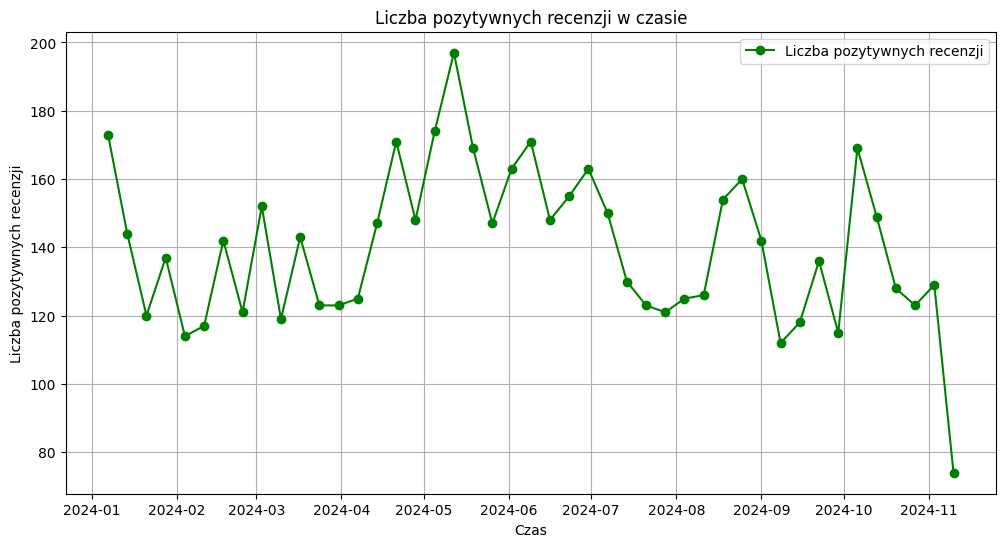

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob

# # Wczytanie danych
# df = reviews.copy()  # Upewnij się, że reviews to ramka danych
# print(df.head())

# # Upewnienie się, że kolumna 'at' (data) jest w formacie datetime
# df['at'] = pd.to_datetime(df['at'], errors='coerce')

# # Inicjalizacja narzędzia do analizy sentymentu
# sia = SentimentIntensityAnalyzer()  # VADER

# # Obliczanie sentymentu za pomocą VADER
# df['vader_sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else None)

# # Upewnienie się, że kolumny sentymentu są liczbami
# df['vader_sentiment'] = pd.to_numeric(df['vader_sentiment'], errors='coerce')

# # Usunięcie błędnych wartości
# df = df.dropna(subset=['vader_sentiment'])

# # Grupowanie danych tygodniowo
# negative_reviews = df[df['vader_sentiment'] > 0.5].groupby(pd.Grouper(key='at', freq='W'))['content'].count()

# # Wizualizacja liczby negatywnych recenzji w czasie
# plt.figure(figsize=(12, 6))
# plt.plot(negative_reviews.index, negative_reviews.values, marker='o', color='green', label='Liczba pozytywnych recenzji')
# plt.title("Liczba pozytywnych recenzji w czasie")
# plt.xlabel("Czas")
# plt.ylabel("Liczba pozytywnych recenzji")
# plt.legend()
# plt.grid()
# plt.show()

In [7]:
biggest_drops

,at,score,vader_sentiment,textblob_sentiment,sentiment_change
38,2024-09-29,3.660870,0.289812,0.337130,-0.131983
14,2024-04-14,3.503401,0.239354,0.299511,-0.128973
32,2024-08-18,3.363636,0.197489,0.198797,-0.128236
8,2024-03-03,3.980263,0.344264,0.349738,-0.113124
25,2024-06-30,3.920245,0.269532,0.260054,-0.089308


In [38]:
# import pandas as pd
# from IPython.display import display

# # Tworzenie DataFrame z unikalnymi wersjami i datami pierwszego pojawienia się
# unique_versions_dates = reviews.groupby('review_created_version')['at'].min().reset_index()

# # Sortowanie wyników po dacie rosnąco
# unique_versions_dates = unique_versions_dates.sort_values('at')

# # Ustawienie opcji Pandas do wyświetlenia pełnej tabeli
pd.set_option('display.max_rows', False)  # Wyświetl wszystkie wiersze
pd.set_option('display.max_columns', False)  # Wyświetl wszystkie kolumny

# # Wyświetlenie tabeli
# display(unique_versions_dates)

                              review_id  \
0  a26cd7bf-843a-4f95-b5da-af095a5981da   
1  4f9945dd-e83c-4b64-9a55-5289b6589b86   
2  211f6167-e987-4a5e-a57f-814f985a1c82   
3  5355151c-7b86-468e-bb97-ab4aa94b3324   
4  cde023d8-dfa5-4a96-88d4-c27907674479   

                                             content  score  \
0  Downloading this new version sadly I lost the ...      1   
1  Very good tracking app. Only gripe is this AI ...      5   
2  I have a refund request until now there not gi...      1   
3  Strava is good. But Strava stopped showing mon...      4   
4  Love this app to track your fitness level in r...      5   

  review_created_version                  at app_version  \
0                 384.11 2024-11-07 11:53:27      384.11   
1                 383.11 2024-11-07 09:16:11      383.11   
2                 383.11 2024-11-07 04:45:47      383.11   
3                 383.11 2024-11-07 03:36:08      383.11   
4                 383.11 2024-11-07 02:18:37      383.11   

 

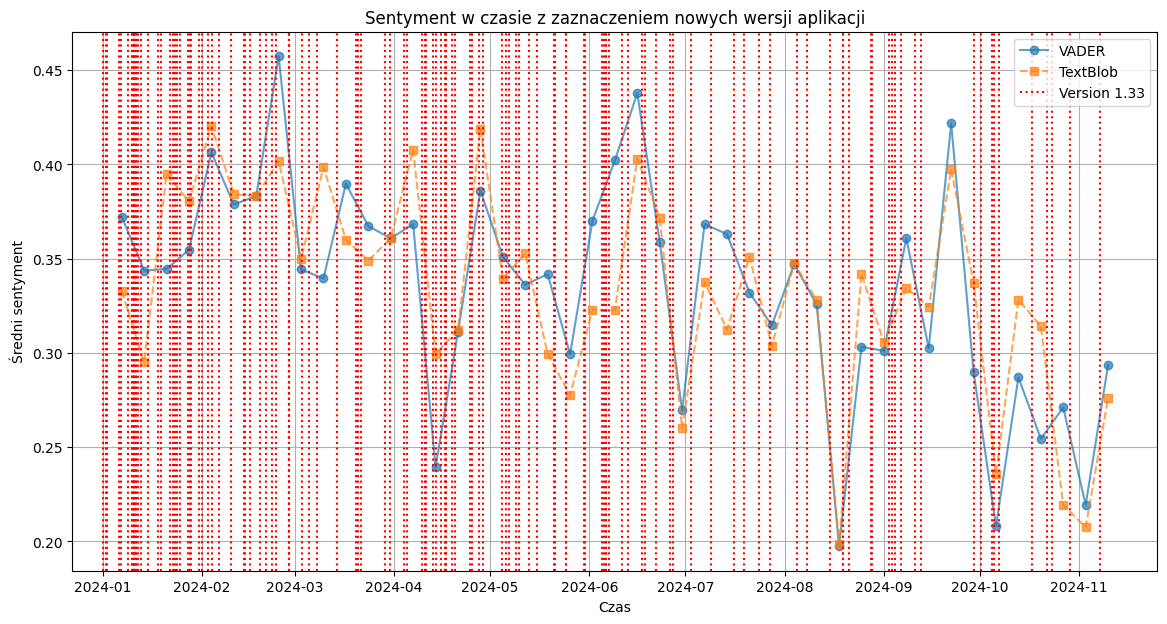

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Wczytanie danych
df = reviews.copy()  # Upewnij się, że reviews to ramka danych
print(df.head())

# Upewnienie się, że kolumna 'at' (data) jest w formacie datetime
df['at'] = pd.to_datetime(df['at'], errors='coerce')

# Inicjalizacja narzędzi do analizy sentymentu
sia = SentimentIntensityAnalyzer()  # VADER

# Obliczanie sentymentu za pomocą VADER
df['vader_sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else None)

# Obliczanie sentymentu za pomocą TextBlob
df['textblob_sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)

# Upewnienie się, że kolumny sentymentu są liczbami
df['vader_sentiment'] = pd.to_numeric(df['vader_sentiment'], errors='coerce')
df['textblob_sentiment'] = pd.to_numeric(df['textblob_sentiment'], errors='coerce')

# Usunięcie braków w danych sentymentu
df = df.dropna(subset=['vader_sentiment', 'textblob_sentiment'])

# 1. Obliczenie średniej i mediany sentymentu dla każdej wersji aplikacji
version_sentiment = df.groupby('review_created_version').agg(
    vader_mean=('vader_sentiment', 'mean'),
    vader_median=('vader_sentiment', 'median'),
    textblob_mean=('textblob_sentiment', 'mean'),
    textblob_median=('textblob_sentiment', 'median'),
).reset_index()

print(version_sentiment)

# 2. Agregacja sentymentu co tydzień
df.set_index('at', inplace=True)
weekly_sentiment = df.resample('W').mean(numeric_only=True)  # Agregacja tygodniowa

# 3. Wyznaczenie momentów wprowadzenia nowych wersji
df.reset_index(inplace=True)  # Przywrócenie indeksu
new_versions = df.groupby('review_created_version')['at'].min().reset_index()
new_versions = new_versions.sort_values('at')  # Posortowanie po dacie
print(new_versions)

# 4. Wizualizacja sentymentu w czasie z zaznaczeniem nowych wersji
plt.figure(figsize=(14, 7))
plt.plot(weekly_sentiment.index, weekly_sentiment['vader_sentiment'], label='VADER', linestyle='-', marker='o', alpha=0.7)
plt.plot(weekly_sentiment.index, weekly_sentiment['textblob_sentiment'], label='TextBlob', linestyle='--', marker='s', alpha=0.7)

# Dodanie linii pionowych dla nowych wersji
for _, row in new_versions.iterrows():
    plt.axvline(x=row['at'], color='red', linestyle=':', label=f"Version {row['review_created_version']}" if row.name == 0 else None)

plt.title("Sentyment w czasie z zaznaczeniem nowych wersji aplikacji")
plt.xlabel("Czas")
plt.ylabel("Średni sentyment")
plt.legend()
plt.grid()
plt.show()